##Check for GPU
In order for our deep learning models to run as fast as possible, we'll need access to a GPU.

In [1]:
# Check for GPU
!nvidia-smi -L

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tensorflow_hub

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


#Getting our workspace ready
Before we get started, since we'll be using TensorFlow 2.x and TensorFlow Hub (TensorFlow Hub), let's import them.

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)

TF version: 2.12.0-rc0
Hub version: 0.13.0


# Getting data ready

#Accessing the data
Now the data files we're working with are available on our Google Drive, we can start to check it out.

Let's start with labels.csv which contains all of the image ID's and their assosciated dog breed (our data and labels).

In [2]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [3]:
# Create pathnames from image ID's
filenames = ["train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10 filenames
filenames[:10]

['train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'train/001cdf01b096e06d78e9e5112d419397.jpg',
 'train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'train/002a283a315af96eaea0e28e7163b21b.jpg',
 'train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [4]:
len(filenames)

10222

In [5]:
import numpy as np
labels = labels_csv["breed"].to_numpy() # convert labels column to NumPy array
labels[:10]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'bedlington_terrier', 'borzoi', 'basenji',
       'scottish_deerhound'], dtype=object)

In [6]:
len(labels)

10222

In [7]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories.")

Number of labels matches number of filenames!


In [8]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [9]:
# Turn every label into a boolean array
boolean_labels = [label == np.array(unique_breeds) for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

## Creating our own validation set

In [10]:
# Setup X & y variables
X = filenames
y = boolean_labels

## Preprocessing images (turning images into Tensors)

In [11]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42]) # read in an image
image.shape

(257, 350, 3)

In [12]:
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

In [13]:
# Define image size
IMG_SIZE = 224

def process_image(image_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  # Read in image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size (224, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

## Creating data batches

In [14]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [15]:
# Define the batch size, 32 is a good default
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels

    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch


## Creating and training a model

In [17]:
# #Resnet
# MODEL_URL = "https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5"
# #EfficientNet
# MODEL_URL = "https://tfhub.dev/tensorflow/efficientnet/b0/classification/1"
# #InceptionV3
# MODEL_URL = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"
# #Xception
# MODEL_URL = "https://tfhub.dev/google/imagenet/xception/classification/5"
# #NASNetLarge
# MODEL_URL = "https://tfhub.dev/google/imagenet/nasnet_large/classification/5"
# #InceptionResNetV2
MODEL_URL = "https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/5"

In [16]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_breeds) # number of unique labels

# Setup model URL from TensorFlow Hub
# mobilenet
#MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

In [21]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(), # Our model wants to reduce this (how wrong its guesses are)
      optimizer=tf.keras.optimizers.Adam(), # A friend telling our model how to improve its guesses
      metrics=["accuracy"] # We'd like this to go up
  )

  # Build the model
  model.build(INPUT_SHAPE) # Let the model know what kind of inputs it'll be getting

  return model

In [18]:
#Learning Rate Annealer
from tensorflow.keras.callbacks import ReduceLROnPlateau
lrr= ReduceLROnPlateau(monitor='val_accuracy', factor=.01, patience=3, min_lr=1e-5,verbose = 1)

# Create early stopping (once our model stops improving, stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3) # stops after 3 rounds of no improvements

# How many rounds should we get the model to look through the data?
NUM_EPOCHS = 20 

#Training a model (on a subset of data)

In [19]:
# Plot the validation and training data separately
import matplotlib.pyplot as plt
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

## Training a model (on the full data)

In [20]:
# Import train_test_split from Scikit-Learn
from sklearn.model_selection import train_test_split

# Split them into training and validation using NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(8177, 8177, 2045, 2045)

In [21]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [26]:
# Create a model
InceptionResNetV2_model = create_model()

# Create new TensorBoard session everytime we train a model
#tensorboard = create_tensorboard_callback()

# Fit the model to the data passing it the callbacks we created
history_InceptionResNetV2 = InceptionResNetV2_model.fit(x=train_data,
        epochs=NUM_EPOCHS,
        validation_data=val_data,
        validation_freq=1, # check validation metrics every epoch
        callbacks=[early_stopping, lrr])

Building model with: https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/5
Epoch 1/20
256/256 [==============================] - 521s 2s/step - loss: 1.0427 - accuracy: 0.7752 - val_loss: 0.6860 - val_accuracy: 0.8328 - lr: 0.0010
Epoch 2/20
256/256 [==============================] - 524s 2s/step - loss: 0.4528 - accuracy: 0.8705 - val_loss: 0.7122 - val_accuracy: 0.8328 - lr: 0.0010
Epoch 3/20
256/256 [==============================] - 496s 2s/step - loss: 0.3349 - accuracy: 0.8972 - val_loss: 0.7288 - val_accuracy: 0.8293 - lr: 0.0010
Epoch 4/20
256/256 [==============================] - 494s 2s/step - loss: 0.2876 - accuracy: 0.9090 - val_loss: 0.8121 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 5/20
256/256 [==============================] - 500s 2s/step - loss: 0.2337 - accuracy: 0.9244 - val_loss: 0.7915 - val_accuracy: 0.8298 - lr: 0.0010
Epoch 6/20
256/256 [==============================] - 498s 2s/step - loss: 0.2056 - accuracy: 0.9321 - val_loss: 0.8663 - val_ac

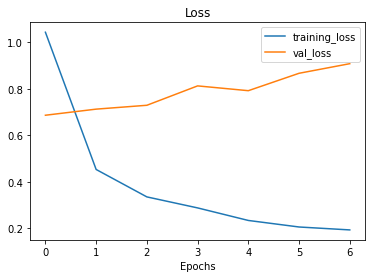

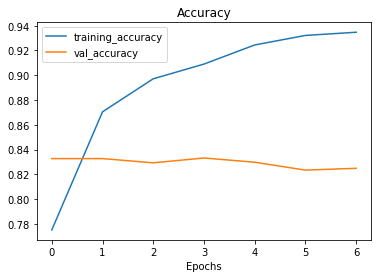

In [28]:
plot_loss_curves(history_InceptionResNetV2)

Creating training data batches...
Creating validation data batches...


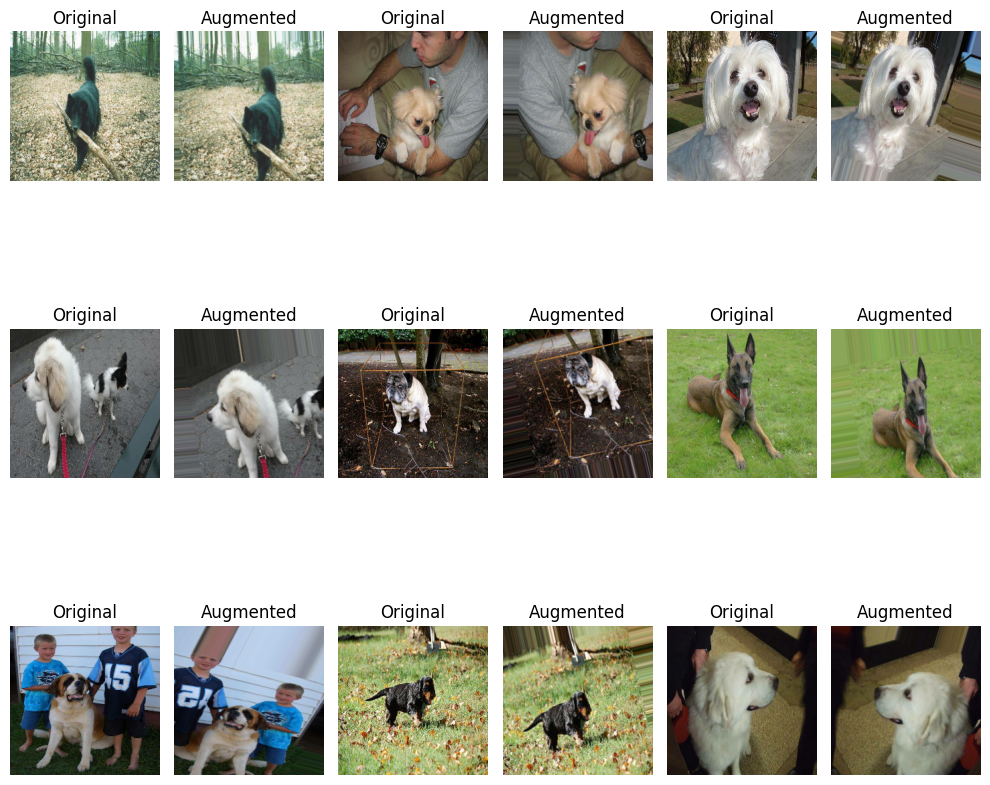

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Define the batch size
BATCH_SIZE = 32

# Define data augmentation parameters
data_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define the function to apply data augmentation to an image
def apply_data_augmentation(image):
    image = tf.expand_dims(image, 0)  # Add batch dimension
    augmented_image = data_augmentation.flow(image, batch_size=1)[0]
    augmented_image = tf.squeeze(augmented_image, axis=0)  # Remove batch dimension
    return augmented_image

# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

# Print the first batch of images and labels with augmented images
for images, labels in train_data.take(1):
    augmented_images = [apply_data_augmentation(image) for image in images]

    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 6, i*2+1)
        plt.imshow(images[i])
        plt.title("Original")
        plt.axis("off")
        plt.subplot(3, 6, i*2+2)
        plt.imshow(augmented_images[i])
        plt.title("Augmented")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


In [23]:
import tensorflow as tf

# Define your data augmentation function
def apply_data_augmentation(image, label):
    # Apply your desired data augmentation operations using TensorFlow functions
    # For example, you can use tf.image functions for common augmentations
    augmented_image = tf.image.random_flip_left_right(image)
    augmented_image = tf.image.random_flip_up_down(augmented_image)
    augmented_image = tf.image.random_brightness(augmented_image, max_delta=0.2)
    augmented_image = tf.image.random_contrast(augmented_image, lower=0.5, upper=1.5)

    return augmented_image, label

# Apply data augmentation using TensorFlow's map function
augmented_data = train_data.map(apply_data_augmentation)


In [24]:
from tensorflow.keras.applications.xception import Xception

# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_breeds) # number of unique labels

# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE):
    print("Building Xception model")

    # Load the Xception model
    base_model = Xception(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = False

    # Setup the model layers
    model = tf.keras.Sequential([
        base_model,  # Layer 1 (input layer)
        tf.keras.layers.GlobalAveragePooling2D(),  # Layer 2
        tf.keras.layers.Dense(units=OUTPUT_SHAPE, activation="softmax")  # Layer 3 (output layer)
    ])

    # Compile the model
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),  # Our model wants to reduce this (how wrong its guesses are)
        optimizer=tf.keras.optimizers.Adam(),  # A friend telling our model how to improve its guesses
        metrics=["accuracy"]  # We'd like this to go up
    )

    return model

# Create a model
Xception_model = create_model()

# Fit the model to the data passing it the callbacks we created
# history_Xception = Xception_model.fit(x=train_data,
#         epochs=NUM_EPOCHS,
#         validation_data=val_data,
#         validation_freq=1, # check validation metrics every epoch
#         callbacks=[early_stopping, lrr])

Building Xception model


In [25]:
# Create a model
Xception_model_augmented_data = create_model()

# Fit the model to the data passing it the callbacks we created
history_Xception_augmented_data = Xception_model_augmented_data.fit(x=augmented_data,
        epochs=NUM_EPOCHS,
        validation_data=val_data,
        validation_freq=1, # check validation metrics every epoch
        callbacks=[early_stopping, lrr])

Building Xception model
Epoch 1/20
256/256 [==============================] - 1260s 5s/step - loss: 2.2987 - accuracy: 0.4606 - val_loss: 0.8184 - val_accuracy: 0.7707 - lr: 0.0010
Epoch 2/20
256/256 [==============================] - 1248s 5s/step - loss: 1.3983 - accuracy: 0.6205 - val_loss: 0.7550 - val_accuracy: 0.7775 - lr: 0.0010
Epoch 3/20
256/256 [==============================] - 1100s 4s/step - loss: 1.2310 - accuracy: 0.6532 - val_loss: 0.7221 - val_accuracy: 0.7907 - lr: 0.0010
Epoch 4/20
256/256 [==============================] - 1099s 4s/step - loss: 1.0820 - accuracy: 0.6956 - val_loss: 0.7111 - val_accuracy: 0.7892 - lr: 0.0010
Epoch 5/20
256/256 [==============================] - 1096s 4s/step - loss: 1.0137 - accuracy: 0.7113 - val_loss: 0.7038 - val_accuracy: 0.7897 - lr: 0.0010
Epoch 6/20
256/256 [==============================] - 1074s 4s/step - loss: 0.9010 - accuracy: 0.7481 - val_loss: 0.7357 - val_accuracy: 0.7956 - lr: 0.0010
Epoch 7/20
256/256 [==============

In [38]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1) # verbose shows us how long there is to go
predictions

7/7 [==============================] - 1s 91ms/step


array([[2.4622239e-03, 3.6776951e-04, 1.8056007e-03, ..., 1.8064378e-04,
        5.9948186e-05, 4.6045296e-03],
       [2.0053834e-03, 1.1352785e-03, 5.7195436e-02, ..., 9.4607443e-04,
        2.6479845e-03, 9.2693366e-04],
       [9.0295334e-06, 9.7081349e-05, 2.5385780e-05, ..., 1.1826957e-04,
        2.4194262e-05, 4.8665202e-04],
       ...,
       [8.9100649e-06, 1.8342840e-04, 5.5692846e-05, ..., 2.6348642e-05,
        1.3620982e-05, 6.7897090e-06],
       [6.7125197e-04, 1.9717285e-04, 1.5877587e-04, ..., 1.3287811e-04,
        5.9397298e-05, 2.6004985e-03],
       [4.1947383e-04, 1.6519896e-05, 3.1544794e-03, ..., 1.0411539e-02,
        1.4139963e-03, 8.1898725e-05]], dtype=float32)

In [39]:
# First prediction
print(predictions[0])
print(f"Max value (probability of prediction): {np.max(predictions[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(predictions[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(predictions[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {unique_breeds[np.argmax(predictions[0])]}") # the predicted label


[2.46222387e-03 3.67769506e-04 1.80560071e-03 9.42602055e-05
 1.13555300e-03 4.49530999e-05 4.51980866e-02 3.57988320e-04
 9.06344576e-05 6.42904546e-04 4.12743626e-04 2.55031511e-04
 6.02446635e-05 2.85462829e-05 1.67319865e-03 1.43467821e-03
 1.49428248e-04 1.54198468e-01 1.42139907e-05 6.82214959e-05
 1.80212141e-03 7.64694065e-04 1.22098336e-05 3.34155187e-03
 2.42895621e-05 4.93751140e-04 2.26058453e-01 1.50386681e-04
 9.35125339e-04 6.61559112e-04 9.08427537e-05 6.55476004e-03
 1.84279750e-04 1.59667779e-05 3.08575618e-05 7.31641203e-02
 7.32265908e-05 3.44364642e-04 9.10395320e-05 5.24913077e-04
 7.30301719e-04 1.56643684e-04 4.54163710e-05 6.02303015e-04
 1.69699939e-04 1.52055523e-04 1.54557965e-05 8.56157494e-05
 6.06348272e-04 1.54639871e-04 3.08853283e-04 8.55956227e-04
 4.54012217e-04 8.22286602e-05 1.50936117e-04 5.03964802e-05
 1.17023905e-04 1.52959232e-03 9.85011226e-04 1.69263817e-02
 1.05077226e-03 3.41186678e-05 2.21909559e-03 2.38163084e-05
 2.62232265e-04 2.319936

In [40]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[1])
pred_label

'scotch_terrier'

Now we've got a list of all different predictions our model has made, we'll do the same for the validation images and validation labels.

Remember, the model hasn't trained on the validation data, during the fit() function, it only used the validation data to evaluate itself. So we can use the validation images to visually compare our models predictions with the validation labels.

Since our validation data (val_data) is in batch form, to get a list of validation images and labels, we'll have to unbatch it (using [unbatch()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#unbatch)) and then turn it into an iterator using [as_numpy_iterator()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#as_numpy_iterator).

Let's make a small function to do so

In [41]:
# Create a function to unbatch a batched dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]


(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Now we've got ways to get:

* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make some functions to make these all a bit more visualize.

More specifically, we want to be able to view an image, its predicted label and its actual label (true label).

The first function we'll create will:

* Take an array of prediction probabilities, an array of truth labels, an array of images and an integer.
* Convert the prediction probabilities to a predicted label.
* Plot the predicted label, its predicted probability, the truth label and target image on a single plot.

In [42]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth label and image for sample n.
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title("{} {:2.0f}% ({})".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)


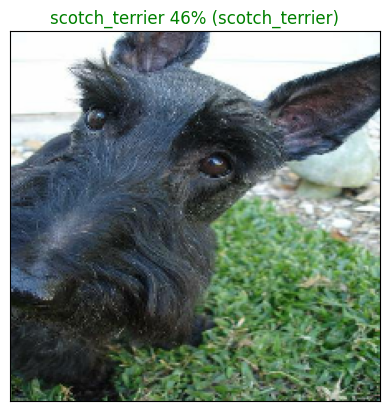

In [43]:
# View an example prediction, original image and truth label
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images)

Let's build a function to demonstrate. The function will:

* Take an input of a prediction probabilities array, a ground truth labels array and an integer.
*Find the predicted label using get_pred_label().
*Find the top 10:
  * Prediction probabilities indexes
  * Prediction probabilities values
  * Prediction labels
* Plot the top 10 prediction probability values and labels, coloring the true label green.


In [44]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plots the top 10 highest prediction confidences along with
  the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

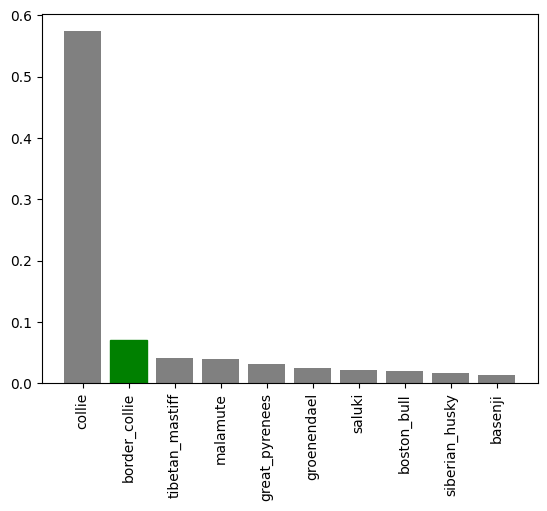

In [45]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

Now we've got some functions to help us visualize our predictions and evaluate our model, let's check out a few.

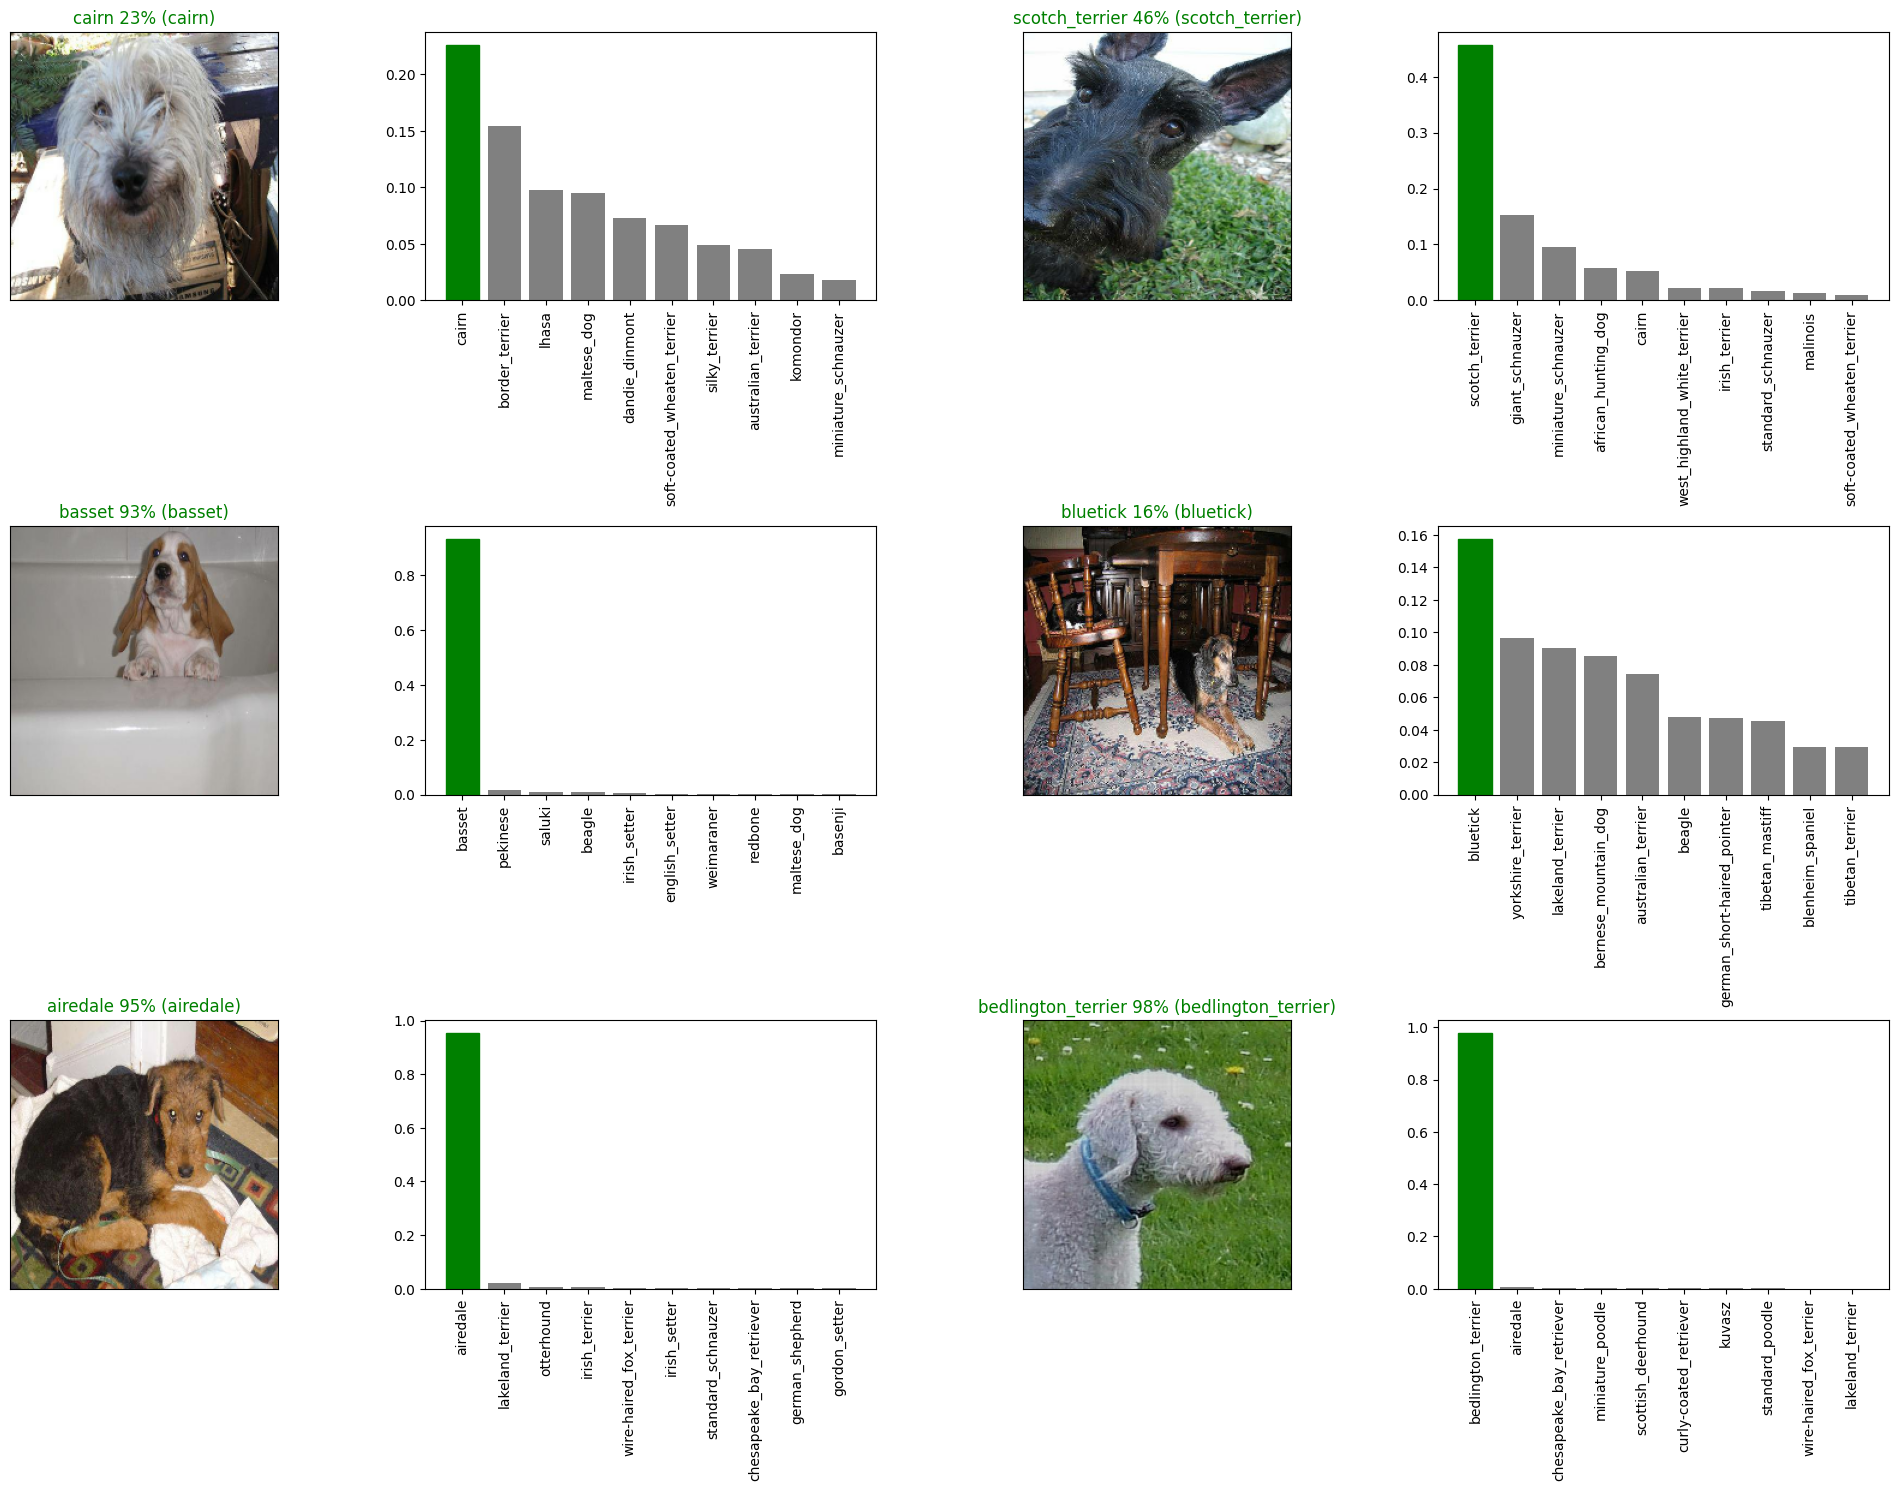

In [46]:
# Let's check a few predictions and their different values
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                labels=val_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

##Training a model (on the full data)

In [47]:
# Remind ourselves of the size of the full dataset
len(X), len(y)

(10222, 10222)

In [48]:
# Import train_test_split from Scikit-Learn
from sklearn.model_selection import train_test_split

# Split them into training and validation using NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(8177, 8177, 2045, 2045)

Creating training data batches...
Creating validation data batches...


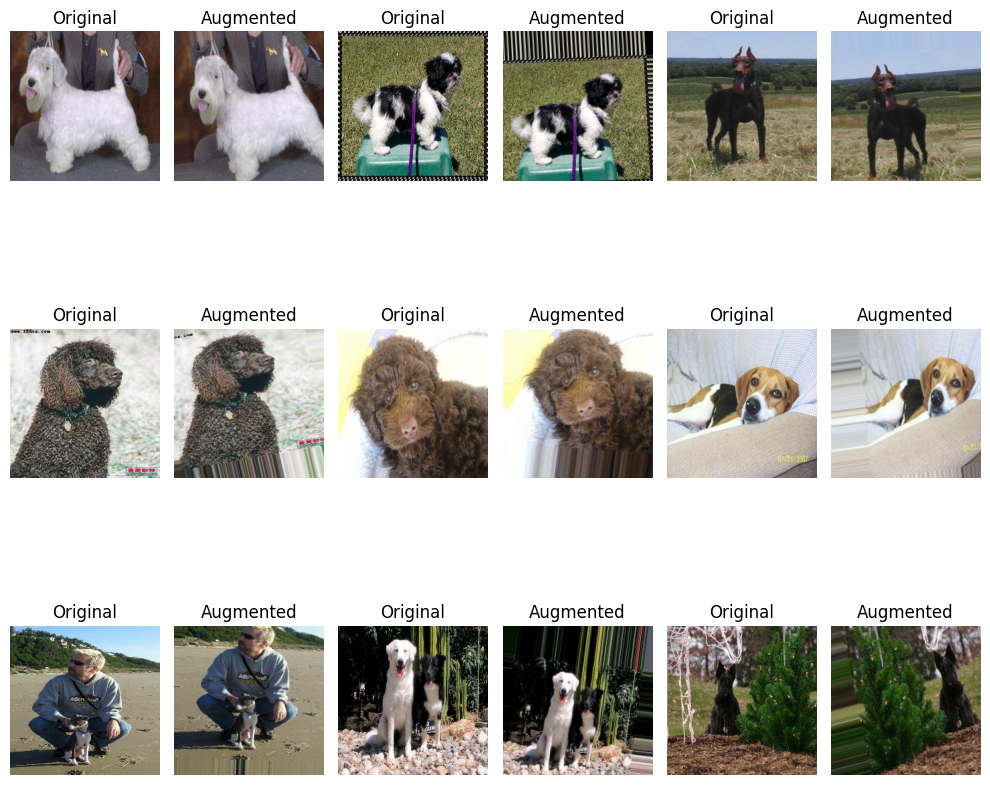

In [58]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Define the batch size
BATCH_SIZE = 32

# Define data augmentation parameters
data_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define the function to apply data augmentation to an image
def apply_data_augmentation(image):
    image = tf.expand_dims(image, 0)  # Add batch dimension
    augmented_image = data_augmentation.flow(image, batch_size=1)[0]
    augmented_image = tf.squeeze(augmented_image, axis=0)  # Remove batch dimension
    return augmented_image

# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

# Print the first batch of images and labels with augmented images
for images, labels in train_data.take(1):
    augmented_images = [apply_data_augmentation(image) for image in images]

    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 6, i*2+1)
        plt.imshow(images[i])
        plt.title("Original")
        plt.axis("off")
        plt.subplot(3, 6, i*2+2)
        plt.imshow(augmented_images[i])
        plt.title("Augmented")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


In [60]:
import tensorflow as tf

# Define your data augmentation function
def apply_data_augmentation(image, label):
    # Apply your desired data augmentation operations using TensorFlow functions
    # For example, you can use tf.image functions for common augmentations
    augmented_image = tf.image.random_flip_left_right(image)
    augmented_image = tf.image.random_flip_up_down(augmented_image)
    augmented_image = tf.image.random_brightness(augmented_image, max_delta=0.2)
    augmented_image = tf.image.random_contrast(augmented_image, lower=0.5, upper=1.5)

    return augmented_image, label

# Apply data augmentation using TensorFlow's map function
augmented_data = train_data.map(apply_data_augmentation)


In [62]:
len(augmented_data) == len(train_data)

True

##Create a model (start with a baseline)
TinyVGG

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

# Create our model (a clone of model_8, except to be multi-class)
model_1 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(120, activation='softmax') # changed to have 10 neurons (same as number of classes) and 'softmax' activation
])

# Compile the model
model_1.compile(loss="categorical_crossentropy", # changed to categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [64]:
# Fit the model
history_1 = model_1.fit(train_data, # now 10 different classes
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=val_data,
                        validation_steps=len(val_data))

Epoch 1/5
256/256 [==============================] - 3479s 14s/step - loss: 4.8030 - accuracy: 0.0102 - val_loss: 4.7859 - val_accuracy: 0.0098
Epoch 2/5
256/256 [==============================] - 36s 140ms/step - loss: 4.7770 - accuracy: 0.0149 - val_loss: 4.7764 - val_accuracy: 0.0132
Epoch 3/5
256/256 [==============================] - 36s 140ms/step - loss: 4.2076 - accuracy: 0.1216 - val_loss: 5.2015 - val_accuracy: 0.0230
Epoch 4/5
256/256 [==============================] - 32s 123ms/step - loss: 1.3448 - accuracy: 0.6993 - val_loss: 9.7757 - val_accuracy: 0.0220
Epoch 5/5
256/256 [==============================] - 32s 123ms/step - loss: 0.1897 - accuracy: 0.9648 - val_loss: 14.5853 - val_accuracy: 0.0215


In [65]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

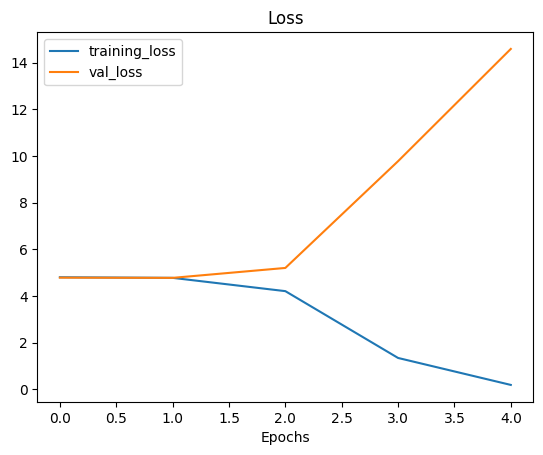

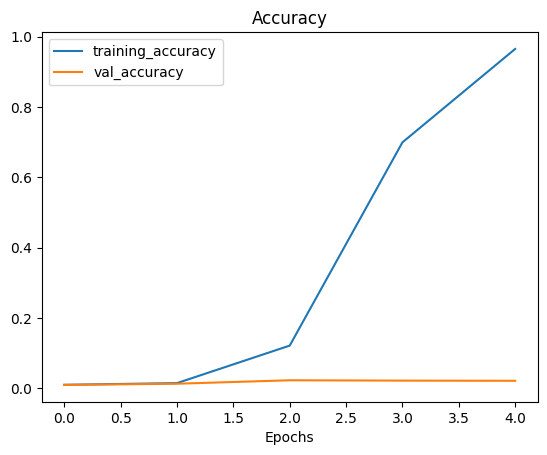

In [66]:
plot_loss_curves(history_1)

In [67]:
# Try a simplified model (removed two layers)
model_2 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(120, activation='softmax')
])

model_2.compile(loss='categorical_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['accuracy'])

history_2 = model_2.fit(train_data,
                          epochs=5,
                          steps_per_epoch=len(train_data),
                          validation_data=val_data,
                          validation_steps=len(val_data))

Epoch 1/5
256/256 [==============================] - 36s 133ms/step - loss: 4.7760 - accuracy: 0.0205 - val_loss: 4.6494 - val_accuracy: 0.0313
Epoch 2/5
256/256 [==============================] - 35s 137ms/step - loss: 3.0900 - accuracy: 0.3227 - val_loss: 5.3475 - val_accuracy: 0.0372
Epoch 3/5
256/256 [==============================] - 31s 122ms/step - loss: 0.6244 - accuracy: 0.8682 - val_loss: 8.1180 - val_accuracy: 0.0396
Epoch 4/5
256/256 [==============================] - 30s 117ms/step - loss: 0.0849 - accuracy: 0.9889 - val_loss: 9.7708 - val_accuracy: 0.0367
Epoch 5/5
256/256 [==============================] - 36s 140ms/step - loss: 0.0244 - accuracy: 0.9985 - val_loss: 10.2910 - val_accuracy: 0.0377


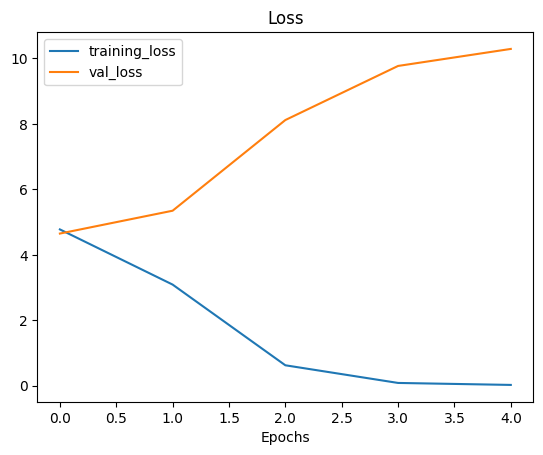

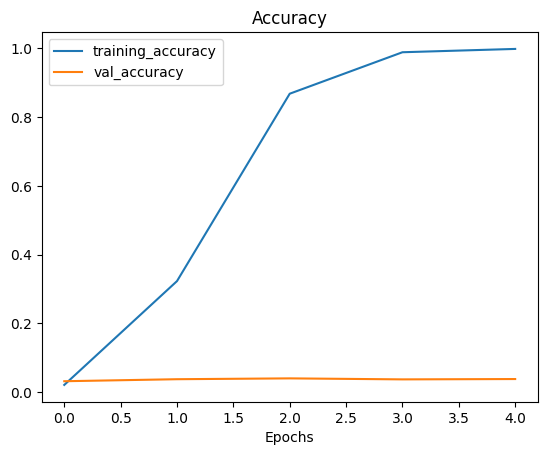

In [68]:
# Check out the loss curves of model_2
plot_loss_curves(history_2)

In [69]:
# Clone the model (use the same architecture)
model_3 = tf.keras.models.clone_model(model_2)

# Compile the cloned model (same setup as used for model_10)
model_3.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_3 = model_3.fit(augmented_data, # use augmented data
                          epochs=5,
                          steps_per_epoch=len(augmented_data),
                          validation_data=val_data,
                          validation_steps=len(val_data))

Epoch 1/5
256/256 [==============================] - 49s 184ms/step - loss: 4.8175 - accuracy: 0.0100 - val_loss: 4.7807 - val_accuracy: 0.0196
Epoch 2/5
256/256 [==============================] - 46s 181ms/step - loss: 4.7426 - accuracy: 0.0331 - val_loss: 4.7385 - val_accuracy: 0.0127
Epoch 3/5
256/256 [==============================] - 47s 181ms/step - loss: 4.5053 - accuracy: 0.0976 - val_loss: 4.7305 - val_accuracy: 0.0200
Epoch 4/5
256/256 [==============================] - 43s 169ms/step - loss: 4.0922 - accuracy: 0.2019 - val_loss: 4.9473 - val_accuracy: 0.0293
Epoch 5/5
256/256 [==============================] - 42s 165ms/step - loss: 3.6286 - accuracy: 0.2864 - val_loss: 4.9211 - val_accuracy: 0.0298


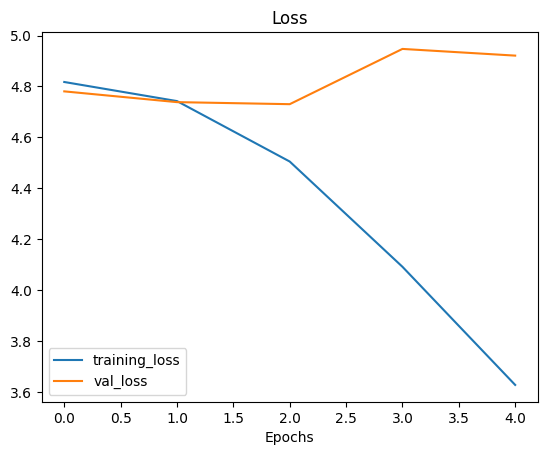

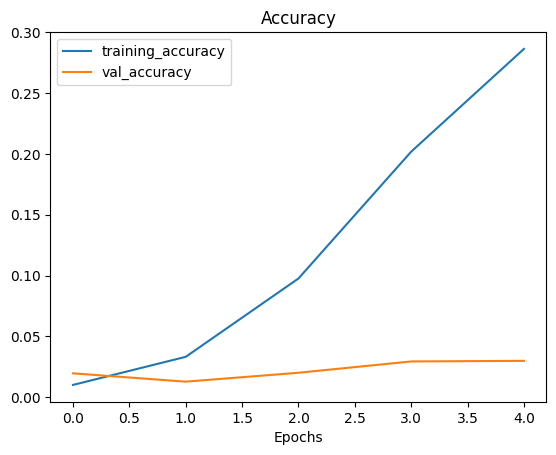

In [70]:
# Check out our model's performance with augmented data
plot_loss_curves(history_3)

In [71]:
# Create a model
model_4 = create_model()

history_4 = model_4.fit(x=augmented_data,
            epochs=20,
            validation_data=val_data,
            validation_freq=1, # check validation metrics every epoch
            callbacks=[early_stopping])


Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/20
256/256 [==============================] - 63s 233ms/step - loss: 2.6371 - accuracy: 0.3890 - val_loss: 0.9189 - val_accuracy: 0.7433
Epoch 2/20
256/256 [==============================] - 48s 186ms/step - loss: 1.3703 - accuracy: 0.6297 - val_loss: 0.7560 - val_accuracy: 0.7839
Epoch 3/20
256/256 [==============================] - 46s 178ms/step - loss: 1.1352 - accuracy: 0.6776 - val_loss: 0.7265 - val_accuracy: 0.7892
Epoch 4/20
256/256 [==============================] - 54s 209ms/step - loss: 1.0366 - accuracy: 0.7070 - val_loss: 0.6960 - val_accuracy: 0.7951
Epoch 5/20
256/256 [==============================] - 48s 185ms/step - loss: 0.9157 - accuracy: 0.7372 - val_loss: 0.6935 - val_accuracy: 0.8005
Epoch 6/20
256/256 [==============================] - 49s 192ms/step - loss: 0.8606 - accuracy: 0.7536 - val_loss: 0.7113 - val_accuracy: 0.7966
Epoch 7/20
256/256 [=================

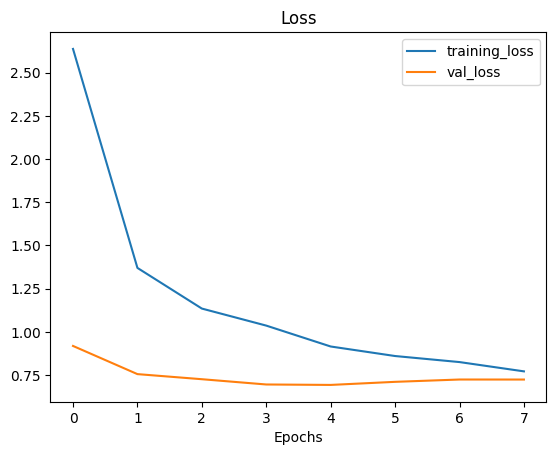

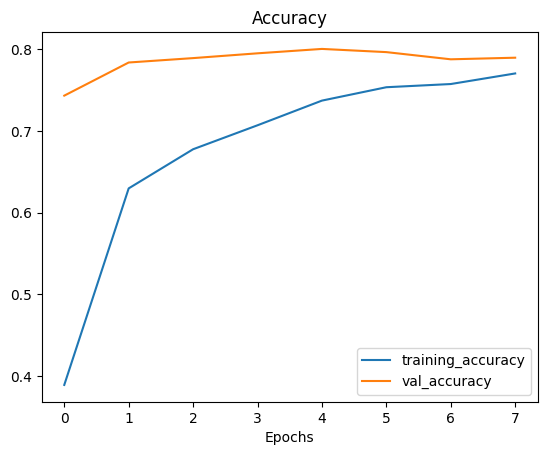

In [72]:
# Check out our model's performance with augmented data with mobilenet_v2
plot_loss_curves(history_4)

In [73]:
#efficientnet_v2
MODEL_URL = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/classification/2"

In [74]:
# Create a model
model_5 = create_model()

history_5 = model_5.fit(x=augmented_data,
            epochs=20,
            validation_data=val_data,
            validation_freq=1, # check validation metrics every epoch
            callbacks=[early_stopping])


Building model with: https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/classification/2
Epoch 1/20
256/256 [==============================] - 59s 197ms/step - loss: 2.9509 - accuracy: 0.3330 - val_loss: 1.1494 - val_accuracy: 0.6714
Epoch 2/20
256/256 [==============================] - 52s 201ms/step - loss: 1.7961 - accuracy: 0.5392 - val_loss: 0.9964 - val_accuracy: 0.7046
Epoch 3/20
256/256 [==============================] - 48s 189ms/step - loss: 1.5450 - accuracy: 0.5929 - val_loss: 0.9620 - val_accuracy: 0.7193
Epoch 4/20
256/256 [==============================] - 48s 187ms/step - loss: 1.3500 - accuracy: 0.6323 - val_loss: 0.9356 - val_accuracy: 0.7311
Epoch 5/20
256/256 [==============================] - 49s 191ms/step - loss: 1.2890 - accuracy: 0.6461 - val_loss: 0.9637 - val_accuracy: 0.7164
Epoch 6/20
256/256 [==============================] - 43s 170ms/step - loss: 1.1993 - accuracy: 0.6642 - val_loss: 1.0067 - val_accuracy: 0.7100
Epoch 7/20
256/256 [========

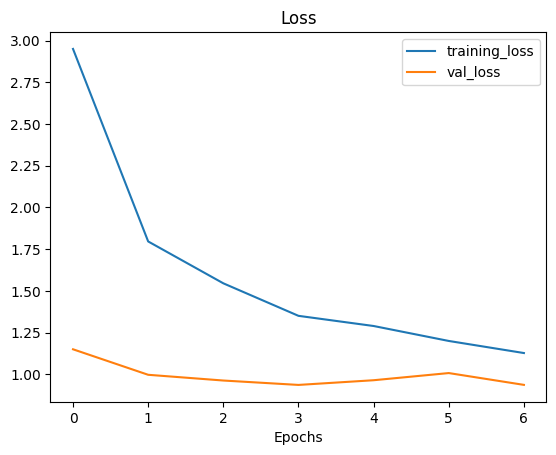

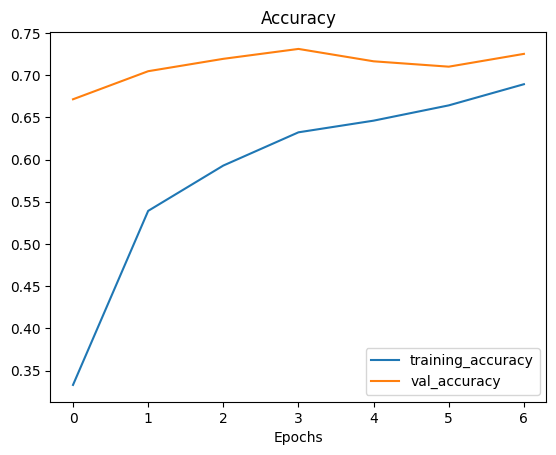

In [75]:
# Check out our model's performance with augmented data with efficientnet
plot_loss_curves(history_5)

In [76]:
# Resnet 50 V2 feature vector
MODEL_URL = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

# Create a model
model_6 = create_model()

history_6 = model_6.fit(x=augmented_data,
            epochs=20,
            validation_data=val_data,
            validation_freq=1, # check validation metrics every epoch
            callbacks=[early_stopping])

Building model with: https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5
Epoch 1/20
256/256 [==============================] - 54s 187ms/step - loss: 2.9455 - accuracy: 0.3325 - val_loss: 1.2356 - val_accuracy: 0.6513
Epoch 2/20
256/256 [==============================] - 45s 175ms/step - loss: 1.8197 - accuracy: 0.5309 - val_loss: 1.0952 - val_accuracy: 0.6870
Epoch 3/20
256/256 [==============================] - 55s 216ms/step - loss: 1.4829 - accuracy: 0.6095 - val_loss: 1.0753 - val_accuracy: 0.7037
Epoch 4/20
256/256 [==============================] - 48s 189ms/step - loss: 1.3557 - accuracy: 0.6407 - val_loss: 1.0778 - val_accuracy: 0.7154
Epoch 5/20
256/256 [==============================] - 45s 175ms/step - loss: 1.1603 - accuracy: 0.6833 - val_loss: 1.0897 - val_accuracy: 0.7125
Epoch 6/20
256/256 [==============================] - 47s 181ms/step - loss: 1.1271 - accuracy: 0.6904 - val_loss: 1.0448 - val_accuracy: 0.7222
Epoch 7/20
256/256 [=========================

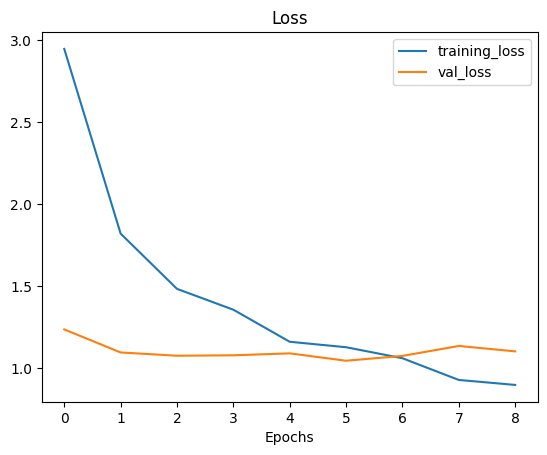

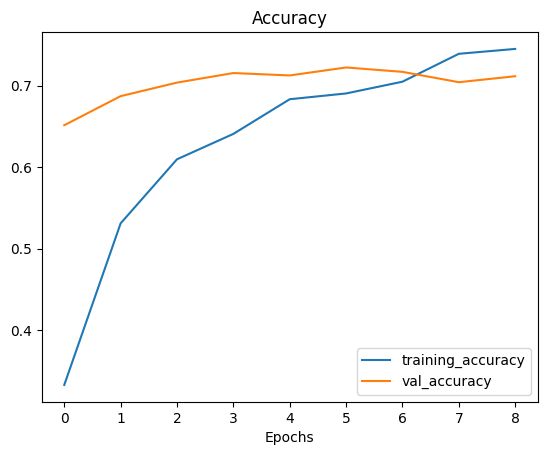

In [77]:
# Check out our model's performance with augmented data with resnet
plot_loss_curves(history_6)

In [89]:
# inception_v3
from keras import models
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D, Dense, Flatten, Dropout
from keras. optimizers import Adam

model_7 = InceptionV3(weights = 'imagenet',
                       include_top = False,
                       input_shape = (224,224,3))

model = models.Sequential()
model.add(model_7)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(120, activation = 'softmax'))

#Freeze pre-trained layers
model.layers[0].trainable = False

#Compile the model
model.compile(Adam(lr=.001), loss="categorical_crossentropy", metrics=['accuracy'])

history_7 = model.fit(x=augmented_data,
            epochs=20,
            validation_data=val_data,
            validation_freq=1, # check validation metrics every epoch
            callbacks=[early_stopping])

Epoch 1/20
256/256 [==============================] - 54s 195ms/step - loss: 2.7927 - accuracy: 0.3492 - val_loss: 0.9804 - val_accuracy: 0.7134
Epoch 2/20
256/256 [==============================] - 62s 244ms/step - loss: 1.8391 - accuracy: 0.5190 - val_loss: 0.9493 - val_accuracy: 0.7071
Epoch 3/20
256/256 [==============================] - 51s 197ms/step - loss: 1.6899 - accuracy: 0.5394 - val_loss: 0.9017 - val_accuracy: 0.7276
Epoch 4/20
256/256 [==============================] - 51s 200ms/step - loss: 1.5891 - accuracy: 0.5590 - val_loss: 0.8488 - val_accuracy: 0.7511
Epoch 5/20
256/256 [==============================] - 49s 192ms/step - loss: 1.5112 - accuracy: 0.5777 - val_loss: 0.8088 - val_accuracy: 0.7589
Epoch 6/20
256/256 [==============================] - 48s 187ms/step - loss: 1.4807 - accuracy: 0.5910 - val_loss: 0.8403 - val_accuracy: 0.7579
Epoch 7/20
256/256 [==============================] - 59s 231ms/step - loss: 1.4099 - accuracy: 0.6012 - val_loss: 0.8500 - val_ac

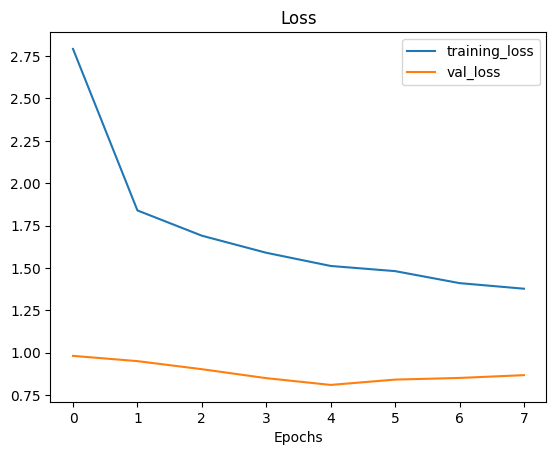

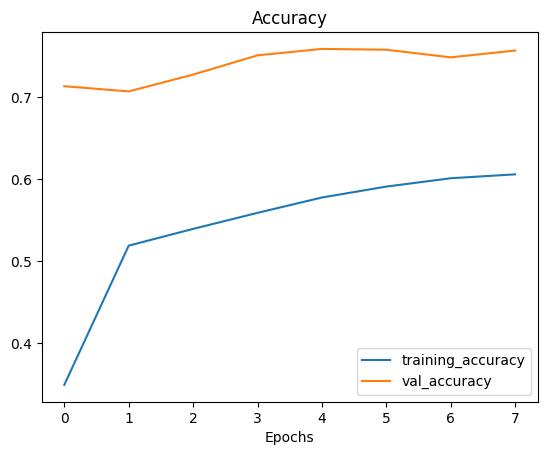

In [90]:
#Check out our model's performance of InceptionV3
plot_loss_curves(history_7)

In [91]:
import os
import datetime
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory with current time
  modeldir = os.path.join("drive/My Drive/Dog-Breed-Identification/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [92]:
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model


In [93]:
# Save model to file
save_model(model_6, suffix="RasNet")

Saving model to: drive/My Drive/Dog-Breed-Identification/models/20230614-04251686716734-RasNet.h5...


'drive/My Drive/Dog-Breed-Identification/models/20230614-04251686716734-RasNet.h5'

In [94]:
 save_model(model_4, suffix="mobilenet_v2")

Saving model to: drive/My Drive/Dog-Breed-Identification/models/20230614-04251686716739-mobilenet_v2.h5...


'drive/My Drive/Dog-Breed-Identification/models/20230614-04251686716739-mobilenet_v2.h5'

In [95]:
save_model(model_5, suffix='efficientnet')

Saving model to: drive/My Drive/Dog-Breed-Identification/models/20230614-04251686716744-efficientnet.h5...


'drive/My Drive/Dog-Breed-Identification/models/20230614-04251686716744-efficientnet.h5'

In [96]:
save_model(model_7, suffix='InceptionV3')

Saving model to: drive/My Drive/Dog-Breed-Identification/models/20230614-04251686716747-InceptionV3.h5...


'drive/My Drive/Dog-Breed-Identification/models/20230614-04251686716747-InceptionV3.h5'

In [ ]:
# Load in the full model
loaded_full_model = load_model('/content/drive/MyDrive/Dog-Breed-Identification/models/20230606-00041686009884-all-images-Adam.h5')


Loading saved model from: /content/drive/MyDrive/Dog-Breed-Identification/models/20230606-00041686009884-all-images-Adam.h5


Making predictions on the test dataset

In [ ]:
# Load test image filenames (since we're using os.listdir(), these already have .jpg)
test_path = "drive/My Drive/Dog-Breed-Identification/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]

test_filenames[:10]

['drive/My Drive/Dog-Breed-Identification/test/e8889cf9d7b2701a85be1c97661b9b26.jpg',
 'drive/My Drive/Dog-Breed-Identification/test/e86bb44f11c953a6d69c548e756f5a3b.jpg',
 'drive/My Drive/Dog-Breed-Identification/test/e83f4c0ff6dec86d89d0f8b70ecd3cea.jpg',
 'drive/My Drive/Dog-Breed-Identification/test/e807c4b5025b0aa4dcbd5df2765aa8e4.jpg',
 'drive/My Drive/Dog-Breed-Identification/test/e826c0ae5dd27876781c10e1be444fd5.jpg',
 'drive/My Drive/Dog-Breed-Identification/test/e800b6c8d2904e205d67ada800907762.jpg',
 'drive/My Drive/Dog-Breed-Identification/test/e78b50f1d12148deef4c564ea4c88050.jpg',
 'drive/My Drive/Dog-Breed-Identification/test/e83d7fa8fdfba0ec577f9c8df811d439.jpg',
 'drive/My Drive/Dog-Breed-Identification/test/e7b608110b0e29120d8740f37e85f3d0.jpg',
 'drive/My Drive/Dog-Breed-Identification/test/e857866af777793d2c114b09ea7a685a.jpg']

In [ ]:
# How many test images are there?
len(test_filenames)

10357

In [ ]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [ ]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

324/324 [==============================] - 167s 469ms/step


In [ ]:
# Check out the test predictions
test_predictions[:10]


array([[3.12909681e-12, 8.13962647e-11, 6.97432260e-12, ...,
        3.53503538e-08, 4.45997880e-14, 1.54533331e-11],
       [2.04210898e-15, 4.49127846e-08, 2.21696229e-12, ...,
        7.94408230e-15, 6.10533894e-15, 9.82376136e-09],
       [2.32101057e-12, 2.74364455e-11, 6.75344676e-12, ...,
        2.75896417e-10, 1.91765935e-07, 6.25837021e-11],
       ...,
       [1.98025542e-13, 1.37458947e-10, 8.38014519e-11, ...,
        2.32126584e-15, 6.47822507e-13, 7.08829086e-14],
       [6.85832086e-11, 5.11827011e-14, 1.31930252e-15, ...,
        1.32032094e-13, 5.08277465e-09, 4.62661864e-14],
       [2.84842913e-16, 1.09301416e-16, 1.19362809e-09, ...,
        7.47986135e-12, 6.57661859e-14, 1.80231307e-12]], dtype=float32)

##Making predictions on custom images

In [ ]:
# Get custom image filepaths
custom_path = "/content/drive/MyDrive/Dog-Breed-Identification/Custom image/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [ ]:
# Turn custom image into batch (set to test data because there are no labels)
custom_data = create_data_batches(custom_image_paths, test_data=True)

Creating test data batches...


In [ ]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

1/1 [==============================] - 1s 864ms/step


In [ ]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['labrador_retriever', 'rottweiler', 'labrador_retriever']

In [ ]:
# Get custom images (our unbatchify() function won't work since there aren't labels)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

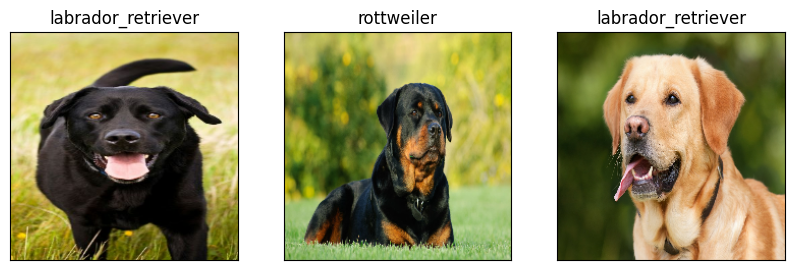

In [ ]:
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)